In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
#import wandb

#from wandb.integration.keras import WandbMetricsLogger

os.environ["KERAS_BACKEND"] = "torch"

#os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'


In [2]:
import keras
import keras_tuner as kt
keras.utils.set_random_seed(812)

2024-06-12 23:33:05.541853: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-12 23:33:05.565581: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 23:33:06.076013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
#wandb.login()

In [4]:
#run = wandb.init(
#    dir = "../results/syntheticdata/",
#    project = "indexes_subsequence_lstm"
#)

In [5]:
#create synthetic multivariate time series random uniform integers
n = 1000
k = 1
data = np.random.randint(1, 6, (k, n)) #k timeseries of length n

data_scenario1 = data.copy()

#select random timewindows of length 5 without overlapping
motif_indexes_scenario1 = []
motif_pattern = [1,1,1,1,1]
p = len(motif_pattern)

In [6]:
max_interval = n//50
print("Max interval between motif", max_interval)
last_index = 0
while True:
    min_interval = p + 10
    index_interval = np.random.randint(min_interval, p + max_interval)
    if last_index + index_interval + p > n:
        break
    last_index = last_index + index_interval
    motif_indexes_scenario1.append(last_index)

print("Planted motifs:", len(motif_indexes_scenario1))
print(motif_indexes_scenario1)
for i in motif_indexes_scenario1:
    for j in range(k):
        data_scenario1[j, i:i+p] = motif_pattern
#save to file as csv
data_scenario1 = data_scenario1.astype(int)
np.savetxt("../data/syntheticdata/scenario1.csv", data_scenario1, delimiter=",")
np.savetxt("../data/syntheticdata/motif_indexes_scenario1.csv", motif_indexes_scenario1, delimiter=",")

Max interval between motif 20
Planted motifs: 51
[24, 43, 67, 86, 109, 132, 147, 166, 185, 206, 221, 242, 257, 277, 300, 322, 346, 367, 391, 409, 430, 447, 469, 487, 511, 526, 544, 562, 580, 598, 613, 629, 649, 668, 686, 703, 721, 745, 767, 785, 800, 823, 840, 860, 879, 902, 918, 933, 951, 967, 988]


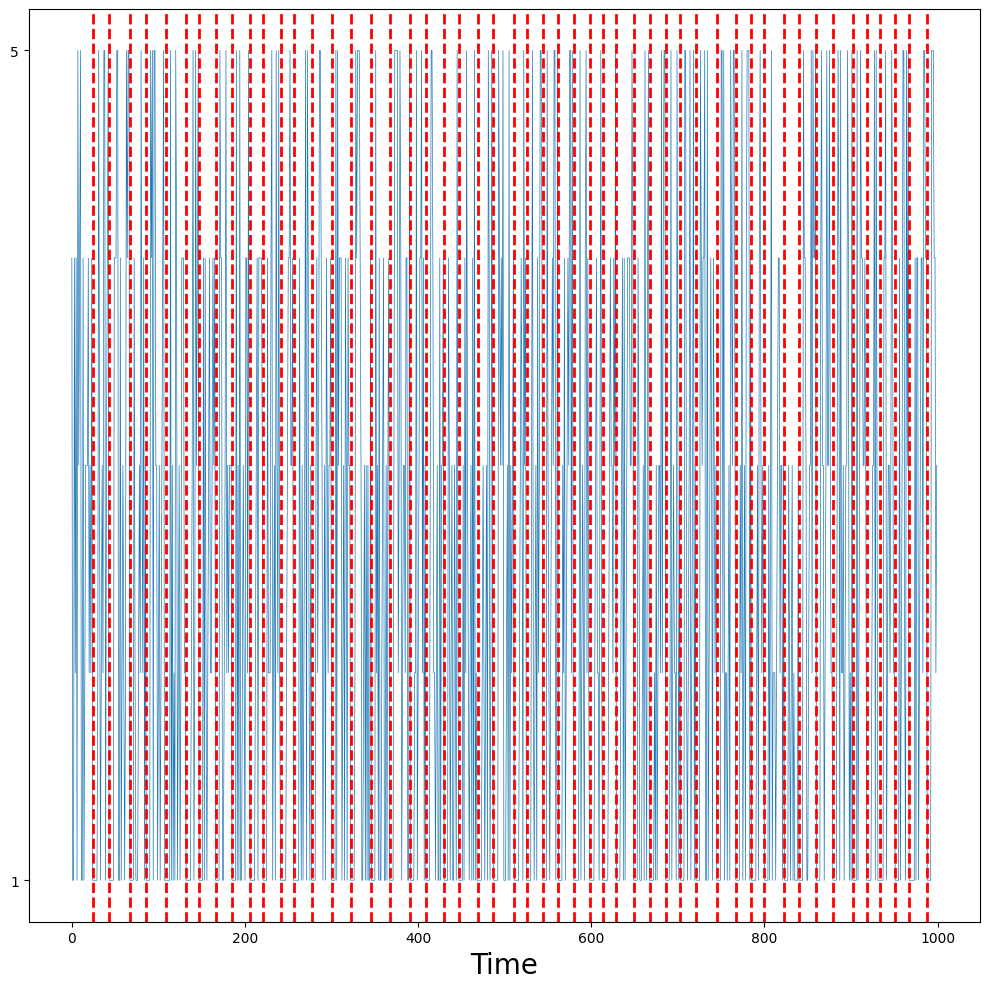

In [7]:
variable_indexes = np.arange(k)
#change the values of the time series in the selected timewindows to the motif pattern
for idx in motif_indexes_scenario1:
    data_scenario1[variable_indexes,idx:idx+p] = motif_pattern

#introduce hint in the data
for idx in motif_indexes_scenario1:
   data_scenario1[variable_indexes,idx-10:idx-10+3] = [1,2,3]

data_scenario1 = data_scenario1.astype(int)
np.savetxt("../data/syntheticdata/scenario1_withhint.csv", data_scenario1, delimiter=",")

#plot multivariate data using subplots in red the planted motifs
fig, axis = plt.subplots(nrows=k, ncols=1, figsize=(10, 10), sharex=True)
for i, variable in enumerate(variable_indexes):
 plt.subplot(len(variable_indexes), 1, i+1)
 #y axis from 1 to 5
 plt.yticks([1,5])
 plt.plot(data_scenario1[variable], linewidth=0.5)
 #plot the planted motifs
 for idx in motif_indexes_scenario1:
    plt.axvline(x=idx, color='r', linestyle='--', linewidth = 2)

plt.xlabel('Time', size=20)
plt.tight_layout()
plt.savefig("../images/data_scenario1_withhint.pdf")
plt.show()

In [8]:
from keras.preprocessing.sequence import pad_sequences

def create_dataset(data,variable_indexes, lookback_period, step, forecast_period, motif_indexes):
    X1, X2, y = list(), list(),  list() # X1: data, X2: indexes of the motifs, y: distance to the next motif
    for idx in range(len(data[0]) - lookback_period - 1):
        if idx % step != 0:
            continue

        window_end_idx = idx + lookback_period
        forecast_period__end = window_end_idx + forecast_period

        #if doesnt exist more matches after the window
        if not any([window_end_idx < motif_idx for motif_idx in motif_indexes]):
            break

        motif_indexes_in_window = [motif_idx for motif_idx in motif_indexes if idx <= motif_idx <= window_end_idx]
        motif_indexes_in_forecast_period = [motif_idx for motif_idx in motif_indexes if window_end_idx < motif_idx <= forecast_period__end]

        if motif_indexes_in_forecast_period:
            next_match_in_forecast_period = motif_indexes_in_forecast_period[0]
        else:
            next_match_in_forecast_period = -1  #no match in forward window but exist in the future

        data_window = data[variable_indexes,idx:window_end_idx]

        data_y = -1 
        if next_match_in_forecast_period != -1:
            # index of the next match relative to the last match in the window
            #data_y = next_match_in_forecast_period - motif_indexes_in_window[-1] 
            # index of the next match relative to the end of the window
            data_y = next_match_in_forecast_period - window_end_idx
        
        X1.append(data_window)
        X2.append(motif_indexes_in_window) 
        y.append(data_y) 

    X2 = pad_sequences(X2, padding='post', value=-1, dtype=int)
    return np.array(X1), np.array(X2) , np.array(y)

In [9]:
#load data
data_scenario1 = np.genfromtxt("../data/syntheticdata/scenario1_withhint.csv", delimiter=",")
data_scenario1 = data_scenario1.astype(int)
motif_indexes_scenario1 = np.genfromtxt("../data/syntheticdata/motif_indexes_scenario1.csv", delimiter=",")
motif_indexes_scenario1= motif_indexes_scenario1.astype(int)

indexes_masking = np.zeros(n)
for motif_index in motif_indexes_scenario1:
    indexes_masking[motif_index:motif_index+p] = 1

data_scenario1_masking = data_scenario1.copy()
data_scenario1_masking = np.vstack((data_scenario1_masking, indexes_masking))

lookback_period = 100 #window size
step = 1 #step size for the sliding window
forecast_period = 50 #forward window size
#x1: past window + masking, x2: indexes of the motif in the window,  y: next relative index of the motif
X1, X2 , y  = create_dataset(data_scenario1_masking,variable_indexes=np.arange(k+1), lookback_period=lookback_period, step=step, forecast_period=forecast_period, motif_indexes=motif_indexes_scenario1)
print(X1.shape, X2.shape, y.shape)
print(X1[0,0], X2[0], y[0])

X1 = np.transpose(X1, (0, 2, 1)) #reshape input to be [samples, time steps, features]
X2 = X2.reshape(X2.shape[0], X2.shape[1], 1) #reshape input to be [samples, time steps, features]
pattern_array = np.tile(motif_pattern, (X1.shape[0], 1)).reshape(X1.shape[0], p, 1)
X1.shape, X2.shape, pattern_array.shape

(888, 2, 100) (888, 6) (888,)
[4. 1. 1. 4. 2. 4. 1. 5. 3. 4. 5. 1. 1. 4. 1. 2. 3. 3. 3. 4. 2. 3. 2. 4.
 1. 1. 1. 1. 1. 1. 2. 5. 3. 1. 2. 3. 2. 5. 5. 1. 3. 4. 5. 1. 1. 1. 1. 1.
 1. 4. 4. 4. 5. 5. 1. 1. 4. 1. 2. 3. 2. 1. 2. 5. 4. 5. 5. 1. 1. 1. 1. 1.
 4. 2. 1. 1. 1. 2. 3. 2. 5. 3. 2. 4. 1. 3. 1. 1. 1. 1. 1. 5. 4. 5. 1. 5.
 5. 3. 3. 1.] [24 43 67 86 -1 -1] 9


((888, 100, 2), (888, 6, 1), (888, 5, 1))

In [10]:
class BlockingTimeSeriesSplit():
  def __init__(self, n_splits):
      self.n_splits = n_splits

  def get_n_splits(self, X, y, groups):
      return self.n_splits

  def split(self, X, y=None, groups=None):
      n_samples = len(X)
      k_fold_size = n_samples // self.n_splits
      indices = np.arange(n_samples)

      margin = 0
      for i in range(self.n_splits):
          start = i * k_fold_size
          stop = start + k_fold_size
          mid = int(0.8 * (stop - start)) + start
          yield indices[start: mid], indices[mid + margin: stop]

In [11]:
import collections
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
import pickle

class CVTuner(kt.engine.tuner.Tuner):

    def __init__(self, *args, **kwargs):
        super(CVTuner, self).__init__(*args, **kwargs)
        # cols are metrics-val_loss, val_mae, val_rmse, val_r2
        self.metrics_history = []
        #if exists load metrics history
        if os.path.exists(os.path.join(self.project_dir, "metrics_history.npy")):
            self.metrics_history = np.load(os.path.join(self.project_dir, "metrics_history.npy"), allow_pickle=True)
        

    def run_trial(self, trial, x, y, *args, **kwargs):
        callbacks = kwargs.pop("callbacks", [])
        callbacks.append(EarlyStopping(patience=10, monitor="val_loss", start_from_epoch = 100))
        verbose = kwargs.pop("verbose", 0)
        batch_size = trial.hyperparameters.Choice('batch_size', values=[8,16,32])

        metrics = collections.defaultdict(list)
        cv = BlockingTimeSeriesSplit(n_splits=5)
        trial_metrics = np.zeros((5, 4), dtype=np.float32)

        for i, (train_indices, test_indices) in enumerate(cv.split(y)):
            #split train indices into train and validation
            mid = int(0.8 * len(train_indices))
            train_indices, val_indices = train_indices[:mid], train_indices[mid:]

            #if x is list
            if isinstance(x, list):
                X_train = [x_in[train_indices] for x_in in x]
                X_val = [x_in[val_indices] for x_in in x]
                X_test = [x_in[test_indices] for x_in in x]
            else:
                X_train, X_val, X_test = x[train_indices], x[val_indices], x[test_indices]
            y_train, y_val, y_test = y[train_indices], y[val_indices], y[test_indices]

            model = self.hypermodel.build(trial.hyperparameters)
            model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=400, batch_size=batch_size, verbose=verbose, callbacks=callbacks)
            test_loss, test_mae, test_rmse, test_r2 = model.evaluate(X_test, y_test) 
            metrics["test_loss"].append(test_loss)
            metrics["test_mae"].append(test_mae)
            metrics["test_rmse"].append(test_rmse)
            metrics["test_r2"].append(test_r2)

            trial_metrics[i] = [test_loss, test_mae, test_rmse, test_r2]
                
        self.save_trial_metrics(trial.trial_id, trial_metrics)
        self.metrics_history.append(trial_metrics)
        print({name: np.mean(values) for name, values in metrics.items()})
        #save cross validation metrics
        return {name: np.mean(values) for name, values in metrics.items()}

    def save_trial_metrics(self, trial_id, metrics):
        fname = os.path.join(self.get_trial_dir(trial_id), "metrics.pickle")
        with open(fname, "wb") as f:
            pickle.dump(metrics, f)

    def save_metrics(self):
        # aggregate metric_history into a matrix (num trials, num folds, num metrics)
        fname = os.path.join(self.project_dir, "metrics_history.npy")
        np.save(fname, np.array(self.metrics_history))
    
    def save_model(self, trial_id, model, step=0):
        fname = os.path.join(self.get_trial_dir(trial_id), "model.pickle")
        with open(fname, "wb") as f:
            pickle.dump(model, f)

    def load_model(self, trial):
        fname = os.path.join(self.get_trial_dir(trial.trial_id), "model.pickle")
        with open(fname, "rb") as f:
            return pickle.load(f)


In [12]:
from keras.optimizers import Adam
from keras.layers import Dense, Masking, Concatenate, Flatten, LSTM
from keras import Input
from tqdm.keras import TqdmCallback
from tcn import TCN, compiled_tcn  
from keras.models import Sequential

class MyHyperModel_DTCN(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Input(shape=self.input_shape))
        model.add(TCN(nb_filters=256, return_sequences=False, dilations=[1, 2, 4, 8, 16, 32]))
        #model.add(Dense(1))
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
        model.compile(loss='mse', optimizer=Adam(learning_rate=hp_learning_rate), metrics=['mae', 'root_mean_squared_error', 'r2_score'])
        return model

In [13]:
tuner = CVTuner(
    hypermodel=MyHyperModel_DTCN(input_shape=(X1.shape[1], X1.shape[2])),
    oracle=kt.oracles.GridSearchOracle(
        objective=kt.Objective("test_loss", "min"),
        max_trials=None),
    directory='../results/syntheticdata',
    project_name='scenario1_dtcn'
)

tuner.search(
        x= X1,
        y= y,
        verbose=0,
        callbacks=[TqdmCallback(verbose=0)],
    )
tuner.save_metrics()

Reloading Tuner from ../results/syntheticdata/scenario1_dtcn/tuner0.json


0epoch [00:00, ?epoch/s]

Traceback (most recent call last):
  File "/home/mgsilva/miniconda3/envs/motifpredenv/lib/python3.9/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/mgsilva/miniconda3/envs/motifpredenv/lib/python3.9/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/tmp/ipykernel_1872245/352273685.py", line 41, in run_trial
    model = self.hypermodel.build(trial.hyperparameters)
  File "/tmp/ipykernel_1872245/1785326057.py", line 15, in build
    model.add(TCN(nb_filters=256, return_sequences=False, dilations=[1, 2, 4, 8, 16, 32]))
  File "/home/mgsilva/miniconda3/envs/motifpredenv/lib/python3.9/site-packages/keras/src/models/sequential.py", line 120, in add
    self._maybe_rebuild()
  File "/home/mgsilva/miniconda3/envs/motifpredenv/lib/python3.9/site-packages/keras/src/models

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/home/mgsilva/miniconda3/envs/motifpredenv/lib/python3.9/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/mgsilva/miniconda3/envs/motifpredenv/lib/python3.9/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/tmp/ipykernel_1872245/352273685.py", line 41, in run_trial
    model = self.hypermodel.build(trial.hyperparameters)
  File "/tmp/ipykernel_1872245/1785326057.py", line 15, in build
    model.add(TCN(nb_filters=256, return_sequences=False, dilations=[1, 2, 4, 8, 16, 32]))
  File "/home/mgsilva/miniconda3/envs/motifpredenv/lib/python3.9/site-packages/keras/src/models/sequential.py", line 120, in add
    self._maybe_rebuild()
  File "/home/mgsilva/miniconda3/envs/motifpredenv/lib/python3.9/site-packages/keras/src/models/sequential.py", line 139, in _maybe_rebuild
    self.build(input_shape)
  File "/home/mgsilva/miniconda3/envs/motifpredenv/lib/python3.9/site-packages/keras/src/layers/layer.py", line 223, in build_wrapper
    original_build_method(*args, **kwargs)
  File "/home/mgsilva/miniconda3/envs/motifpredenv/lib/python3.9/site-packages/keras/src/models/sequential.py", line 183, in build
    x = layer(x)
  File "/home/mgsilva/miniconda3/envs/motifpredenv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/mgsilva/miniconda3/envs/motifpredenv/lib/python3.9/site-packages/tcn/tcn.py", line 316, in build
    self.slicer_layer.build(self.build_output_shape.as_list())
AttributeError: 'tuple' object has no attribute 'as_list'


In [ ]:
tuner.results_summary()

In [ ]:
#get config of the best model
best_trial = tuner.oracle.get_best_trials(1)[0]

print(best_trial.hyperparameters.values)
print(best_trial.metrics.get_best_value("test_mae"))

#load best trial metrics file
cv_metrics = np.load(os.path.join(tuner.get_trial_dir(best_trial.trial_id), "metrics.pickle"), allow_pickle=True)
print(cv_metrics)

metrics = []
#train test split
mid = int(0.8 * len(np.arange(len(X1))))
X1_train, X1_test = X1[:mid], X1[mid:]
X2_train, X2_test = X2[:mid], X2[mid:]
pattern_array_train, pattern_array_test = pattern_array[:mid], pattern_array[mid:]
y_train, y_test = y[:mid], y[mid:]
model = (MyHyperModel_DTCN(time_series_shape=(X1.shape[1], X1.shape[2]), motif_indexes_shape=(X2.shape[1], X2.shape[2]), pattern_shape=(pattern_array.shape[1], pattern_array.shape[2]))).build((best_trial.hyperparameters))
history = model.fit([X1_train, X2_train, pattern_array_train], y_train, validation_data = ([X1_test, X2_test, pattern_array_test], y_test),
            epochs=400, batch_size=best_trial.hyperparameters.values["batch_size"],
            verbose=0, callbacks=[EarlyStopping(patience=10, monitor="val_loss", start_from_epoch = 100),  TqdmCallback(verbose=0)])
metrics.append(model.evaluate([X1_test, X2_test, pattern_array_test], y_test))


keras.utils.plot_model(model, to_file="../images/best_model_lstm_casestudy_scenario1.png", show_shapes=True)
metrics = np.array(metrics)
print(metrics)

In [ ]:
import pandas as pd
logs = pd.DataFrame(history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs["loss"], lw=2, label='training loss')
plt.plot(logs["val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs["mae"], lw=2, label='training MAE')
plt.plot(logs["val_mae"], lw=2, label='validation MAE')
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend(loc='upper right')
plt.show()

In [ ]:
#plot prediction vs true values
y_pred = model.predict([X1_test, X2_test, pattern_array_test])

residuals = y_test - y_pred.flatten()
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.show()